In [8]:
import sys
import numpy as np
from numpy import genfromtxt
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy import stats
from ipfx import feature_extractor
from ipfx import subthresh_features as subt
from ipfx import feature_vectors as fv
from ipfx.sweep import Sweep
from sklearn.preprocessing import minmax_scale
from pyAPisolation.loadABF import loadABF
import sklearn.preprocessing
import pyabf
import logging
import glob
method='trf'

In [9]:
import autograd.numpy as np
from autograd import grad



In [28]:

def exp_grow(t, a, b, alpha):
    return a - b * np.exp(-alpha * t)

def exp_grow_2p(t, a, b1, alphaFast, b2, alphaSlow):
    return a - b1 * np.exp(-alphaFast * t) - b2*np.exp(-alphaSlow*t) 

def exp_grow_clampfit(t, a, b1, alphaFast, b2, alphaSlow):
    return b1 * np.exp((-t)/alphaFast) + b2*np.exp((-t)/alphaSlow) + a

def exp_grow1_clampfit(t, a, b1, alphaFast):
    return b1 * np.exp((-t)/alphaFast) + a

In [29]:
def exp_growth_factor(dataT,dataV,dataI, end_index=300):
    #try:
        
        diff_I = np.diff(dataI)
        upwardinfl = np.argmax(diff_I)

        #Compute out -50 ms from threshold
        dt = dataT[1] - dataT[0]
        offset = 0.01/ dt 

        end_index = int(end_index - offset)


        
        upperC = np.amax(dataV[upwardinfl:end_index])
        lowerC  = np.amin(dataV[upwardinfl:end_index])
        diffC = np.abs(lowerC - upperC)
        t1 = dataT[upwardinfl:end_index] - dataT[upwardinfl]
        curve = curve_fit(exp_grow, t1, dataV[upwardinfl:end_index], maxfev=50000, bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))[0]
        curve2 = curve_fit(exp_grow_clampfit, t1, dataV[upwardinfl:end_index], bounds=([lowerC*1.5, -100, 1e-3,-np.inf, -1e3], [lowerC*0.95, 100, np.inf, np.inf, np.inf]), maxfev=50000000, xtol=None, gtol=None, ftol=1e-12)[0]
        tau = curve[2]
        tau1 = 1/curve2[2]
        tau2 = 1/curve2[4]
        tau_idx = [2, 4]
        fast = tau_idx[np.argmin([tau1, tau2])]
        slow = tau_idx[np.argmax([tau1, tau2])]
        
        curve_out = [curve2[0], curve2[fast-1], curve2[fast], curve2[slow-1], curve2[slow]]


        #plt.subplot(1,2,1)
        plt.plot(t1, dataV[upwardinfl:end_index], c='k', alpha=0.5)
        plt.plot(t1, exp_grow_clampfit(t1, *curve2), label=f'2 phase fit', c='r', alpha=0.5)
        plt.plot(t1, exp_grow1_clampfit(t1, *curve_out[:3]), label=f'Fast phase', c='g', alpha=0.5)
        plt.plot(t1, exp_grow1_clampfit(t1, curve_out[0], *curve_out[3:]), label=f'slow phase', c='b', alpha=0.5)
        plt.title(f" CELL will tau1 {1/curve2[fast]} and tau2 {1/curve2[slow]}")
        #plt.subplot(1,2,2)
        plt.legend()
        #plt.twinx()
        #plt.subplot(1,2,2)
        #dy = curve_detrend(t1, dataV[upwardinfl:end_index], curve2)
         #signal.savgol_filter(nt1p.diff(dataV[upwardinfl:end_index])/np.diff(t1), 71, 2, mode='mirror')
        #plt.plot(t1,dy)
        
        curve_out = [curve2[0], curve2[fast-1], 1/curve2[fast], curve2[slow-1], 1/curve2[slow]]
        return curve_out
    #except:
        return [np.nan, np.nan, np.nan, np.nan, np.nan]

In [21]:
files = glob.glob('C:\\Users\\SMest\\Documents\\clustering-data\\\All IC1s\\*.abf', recursive=True)

In [22]:
cell_type_df = pd.read_csv("C:\\Users\\SMest\\Documents\\clustering-data\\MARM_PVN_IC1\\spike_count_sort_out.csv")
print(cell_type_df.head)
file_names = cell_type_df['filename'].to_numpy()
cell_type_label = cell_type_df['cell_label'].to_numpy()

<bound method NDFrame.head of             filename  label  cell_label  CRH_label  Sag Ratio 001  \
0    2020_01_16_0003      2          -1         -1       0.072335   
1    2020_01_16_0011      1           1         -1       0.053301   
2    2020_01_16_0020      2           3         -1       0.183200   
3    2020_01_16_0025      2          -1         -1       0.200844   
4    2020_01_16_0029      0          -1          0       0.044166   
..               ...    ...         ...        ...            ...   
152         21311038      1           0         -1       0.065753   
153         21311047      1           1         -1       0.069595   
154         21311063      5           1         -1       0.291042   
155         21311074      1          -1         -1       0.123829   
156         21311084      1           1         -1       0.290186   

     Sag Ratio 002  Sag Ratio 003  Sag Ratio 004  Sag Ratio 005  \
0         0.480277       1.081981       1.528664       1.856069   
1      

0
1
[[-108.3069   53.9949   -3.1805 ...  156.0823   -0.0204    0.006 ]
 [-106.5216   50.0759   -8.6345 ...  267.047    -0.0323    0.0086]
 [-107.2083   46.2189  -18.9862 ...  464.3098   -0.0409    0.0085]]
(7,)


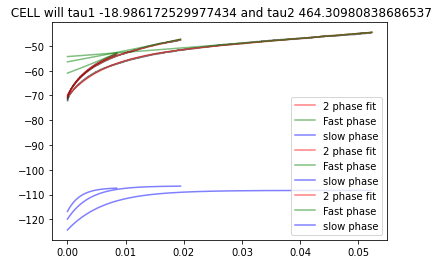

2
[[-116.6046   46.9145   -3.6725 ...   31.3936   -0.117     0.1308]
 [-117.4164   53.3899   -5.8678 ...   36.9204   -0.1589    0.1761]
 [-189.9261  144.1139   -2.6967 ...   33.801    -0.0798    0.0445]]
(7,)


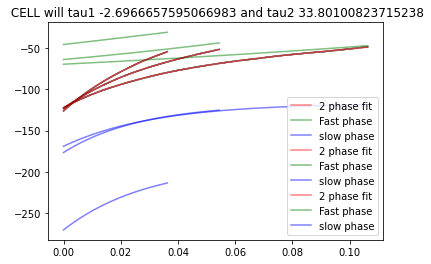

3
[[ -87.0621   19.0436   -5.2077 ...   36.6004   -0.1423    0.1746]
 [-139.9384   67.4094   -4.2809 ...   46.9742   -0.0911    0.0273]
 [-139.5264   61.8617   -8.0044 ...   86.334    -0.0927    0.0225]]
(7,)


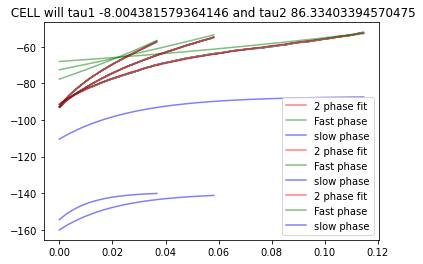

4
[[ -89.5554   51.126    -0.001  ...   13.786    -0.0001    0.0001]
 [-142.4561  104.3004   -0.0666 ...   18.3818   -0.0036    0.0019]
 [ -91.0629   54.5912   -0.001  ...   23.2241   -0.        0.    ]]
(7,)


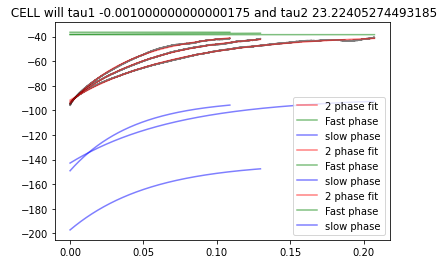

5
6
[[-72.4792  30.8606  -0.001  ...  25.4461  -0.       0.    ]
 [-73.0011  31.7114  -0.001  ...  39.9699  -0.       0.    ]
 [-72.9141  32.1502  -0.001  ...  53.5603  -0.       0.    ]]
(7,)


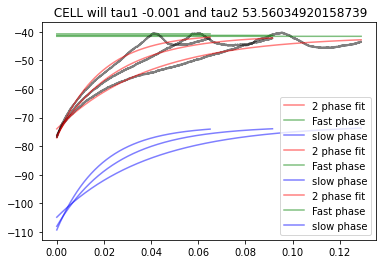

7
8
9
[[ -65.1443   18.4544   -5.029  ...  133.2819   -0.0377    0.0446]
 [-102.8137   58.9252   -1.9987 ...  125.3716   -0.0159    0.0066]
 [ -64.5645   25.6291   -0.001  ...  121.2073   -0.        0.    ]]
(7,)


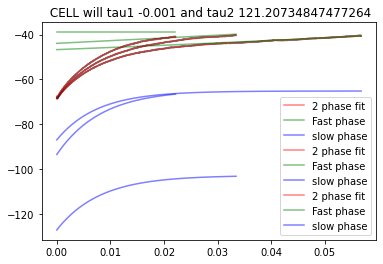

In [23]:
curves = []
label = []
ids = []
max_curve = []
for i, f in enumerate(files[:10]):
    print(i)
    try:
        base = os.path.basename(f)
        base = base.split(".")[0]
        if base in file_names:
            x, y, c = loadABF(f)
            
            temp_curves =[]
            #plt.clf()
            iterd = 0
            for sweepX, sweepY, sweepC in zip(x,y,c):
                spikext = feature_extractor.SpikeFeatureExtractor(filter=0, end=1.25)
                res = spikext.process(sweepX, sweepY, sweepC)
                if res.empty==False and iterd < 3:
                    iterd += 1
                    spike_time = res['threshold_index'].to_numpy()[0]
                    #plt.figure(num=2)
                    curve = exp_growth_factor(sweepX, sweepY, sweepC, spike_time)
                    temp_curves.append(curve)
            temp_curves = np.vstack(temp_curves)
            div = np.ravel((temp_curves[:,2]) / (temp_curves[:,4])).reshape(-1,1)
            
            sum_height= (temp_curves[:,1] + temp_curves[:,3])
            ratio = (temp_curves[:,2] / (temp_curves[:,1] / sum_height)) / (temp_curves[:,4] / (temp_curves[:,3] / sum_height))
            ratio = np.ravel(ratio).reshape(-1,1)
            temp_curves = np.hstack([temp_curves, div, ratio])
            print(temp_curves)
            meanC = np.nanmean(temp_curves, axis=0)
            print(meanC.shape)
            curves.append(meanC)
            label_idx = np.argwhere(file_names==base)
            

            label.append(cell_type_label[label_idx])
            
            ids.append(base)
            plt.savefig(f+".png")
            plt.show()
            
            plt.close()
    except:
        print("fail")
curves = np.vstack(curves)

In [24]:
#lab = sklearn.preprocessing.LabelEncoder()
#int_lab = lab.fit_transform(label)
print(curves)
label = np.ravel(label).reshape(-1,1)
div = np.ravel((curves[:,2]) / (curves[:,4])).reshape(-1,1)
print(div)
sum_height= (curves[:,1] + curves[:,3])
ratio = (curves[:,2] / (curves[:,1]/sum_height)) / (curves[:,4] / (curves[:,3]/sum_height))
ratio = np.ravel(ratio).reshape(-1,1)
curves_out = np.hstack([curves, div, ratio, label])
np.savetxt('curves.csv', curves_out, fmt='%.8f', delimiter=',')
np.savetxt('curves_id.csv', ids, fmt='%s', delimiter=',')
print(curves)

[[-107.3456   50.0966  -10.2671 ...  295.813    -0.0312    0.0077]
 [-141.3157   81.4728   -4.079  ...   34.0383   -0.1186    0.1171]
 [-122.1756   49.4382   -5.831  ...   56.6362   -0.1087    0.0748]
 [-107.6914   70.0059   -0.0229 ...   18.464    -0.0012    0.0007]
 [ -72.7982   31.5741   -0.001  ...   39.6588   -0.        0.    ]
 [ -77.5075   34.3362   -2.3429 ...  126.6203   -0.0179    0.017 ]]
[[-0.0347]
 [-0.1198]
 [-0.103 ]
 [-0.0012]
 [-0.    ]
 [-0.0185]]
[[-107.3456   50.0966  -10.2671 ...  295.813    -0.0312    0.0077]
 [-141.3157   81.4728   -4.079  ...   34.0383   -0.1186    0.1171]
 [-122.1756   49.4382   -5.831  ...   56.6362   -0.1087    0.0748]
 [-107.6914   70.0059   -0.0229 ...   18.464    -0.0012    0.0007]
 [ -72.7982   31.5741   -0.001  ...   39.6588   -0.        0.    ]
 [ -77.5075   34.3362   -2.3429 ...  126.6203   -0.0179    0.017 ]]


C:\Users\SMest\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.


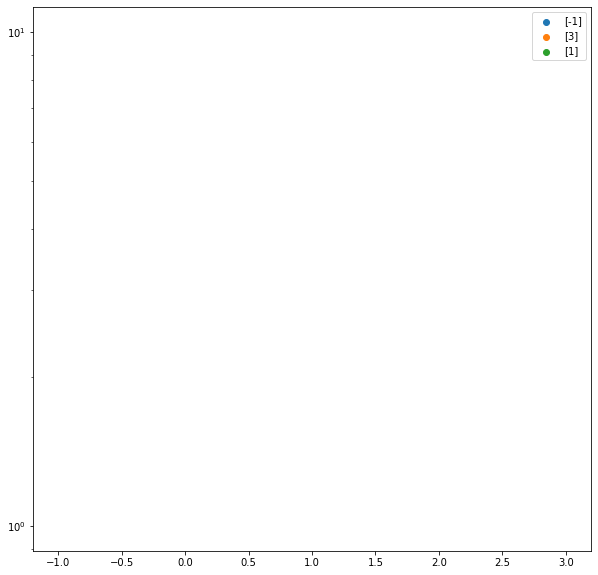

In [25]:
means = []
plt.figure(figsize=(10,10))
plt.clf()
for x in np.unique(label).astype(np.int32):
    idx = np.argwhere(label[:,0]==x).astype(np.int32)
    mcur = curves[idx]
    plt.scatter(np.full(len(idx),  x),  (curves[idx,2]) / (curves[idx,4]), label=label[x])
    means.append(np.nanmean((curves[idx,2]) / (curves[idx,4])))
plt.legend()
plt.yscale('log')
#plt.ylim(0,1)

In [26]:
print(means)

[-0.00926420896393424, -0.0012391976540720138, -0.08583277297337459]


In [27]:
1=1
curves = []
label = []
ids = []
for i, f in enumerate(files[:38]):
    print(i)
    x, y, c = loadABF(f)
    d_name = os.path.dirname(f)
    base = os.path.basename(f)
    ids.append(base)
    label.append(d_name)
    dfs = []
    temp_curves
    plt.clf()
    for sweepX, sweepY, sweepC in zip(x,y,c):
        spikext = feature_extractor.SpikeFeatureExtractor(filter=0)
        res = spikext.process(sweepX, sweepY, sweepC)
        dfs.append(res)
        if res.empty==False:
            if len(non_empty_df) > 1:
                sweep_to_use = non_empty_df[1]
            else:
                sweep_to_use = non_empty_df[-1]
    non_empty_df = np.nonzero(np.invert([df.empty for df in dfs]))[0]
    
    
    try:
        spike_time = dfs[sweep_to_use]['threshold_index'].to_numpy()[0]
        curve = exp_growth_factor(x[sweep_to_use,:], y[sweep_to_use,:], c[sweep_to_use,:], spike_time)
        curves.append(curve)
    except:
        curves.append([np.nan, np.nan, np.nan, np.nan, np.nan])
    plt.show()
print(non_empty_df)

SyntaxError: can't assign to literal (<ipython-input-27-b07f0ea16760>, line 1)